## Libraries and setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import os
import json
import joblib
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(filepath):
    return pd.read_csv(filepath)

def save_dataset(dataset, filepath):
    dataset.to_csv(filepath, index=False)

def dataset_split(X, y, split_size, shuffle=True):
    return train_test_split(X, y, test_size=split_size, shuffle=shuffle, random_state=42)

def sklearn_model_load(directory):
    model = joblib.load(f'{directory}/model.joblib')

    with open(f'{directory}/config.json', 'r') as config_file:
        config = json.load(config_file)

    return model, config

def sklearn_model_save(directory, model, config):
    if not os.path.exists(directory):
        os.makedirs(directory)

    joblib.dump(model, f'{directory}/model.joblib')

    with open(f'{directory}/config.json', 'w') as config_file:
        json.dump(config, config_file)

collective_metrics = {}

## Load and prepare dataset

In [ ]:
scaler = joblib.load('/content/drive/My Drive/Machine Learning/Final Project/scaler.joblib')
encoder = joblib.load('/content/drive/My Drive/Machine Learning/Final Project/encoder.joblib')

In [ ]:
dataset = load_dataset('/content/drive/My Drive/Machine Learning/Final Project/energydata_preprocessed.csv')

X = dataset.drop(columns=['date', 'Appliances'])
y = dataset['Appliances']

## GBM Model

### Train model

In [ ]:
X_train, X_test, y_train, y_test = dataset_split(X, y, 0.2, shuffle=True)

model = GradientBoostingRegressor(
    n_estimators=1500,
    learning_rate=0.15,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=5, n_estimators=1500,
                          random_state=42)

### Load model if already trained

In [ ]:
model, _ = sklearn_model_load('/content/drive/My Drive/Machine Learning/Final Project/Models/gbm')

### Test model

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

numerical_columns = [
    'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
    'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8',
    'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
    'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM'
]

dummy_array = np.zeros((len(y_pred), len(numerical_columns)))

target_index = numerical_columns.index('Appliances')
dummy_array[:, target_index] = y_pred

y_pred_original = scaler.inverse_transform(dummy_array)[:, target_index]

dummy_array[:, target_index] = y_test.values
y_test_original = scaler.inverse_transform(dummy_array)[:, target_index]

mse_original = mean_squared_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)

collective_metrics['gbm'] = {}
collective_metrics['gbm']['mae'] = mae_original
collective_metrics['gbm']['mse'] = mse_original
collective_metrics['gbm']['r2'] = r2_original

print(f"Mean Absolute Error: {mae_original}")
print(f"Mean Squared Error: {mse_original}")
print(f"Root Mean Squared Error: {np.sqrt(mse_original)}")
print(f"R squared: {r2_original}")

Mean Absolute Error: 32.30194073357962
Mean Squared Error: 4234.4590854851385
Root Mean Squared Error: 65.07272151589434
R squared: 0.5768541481552429


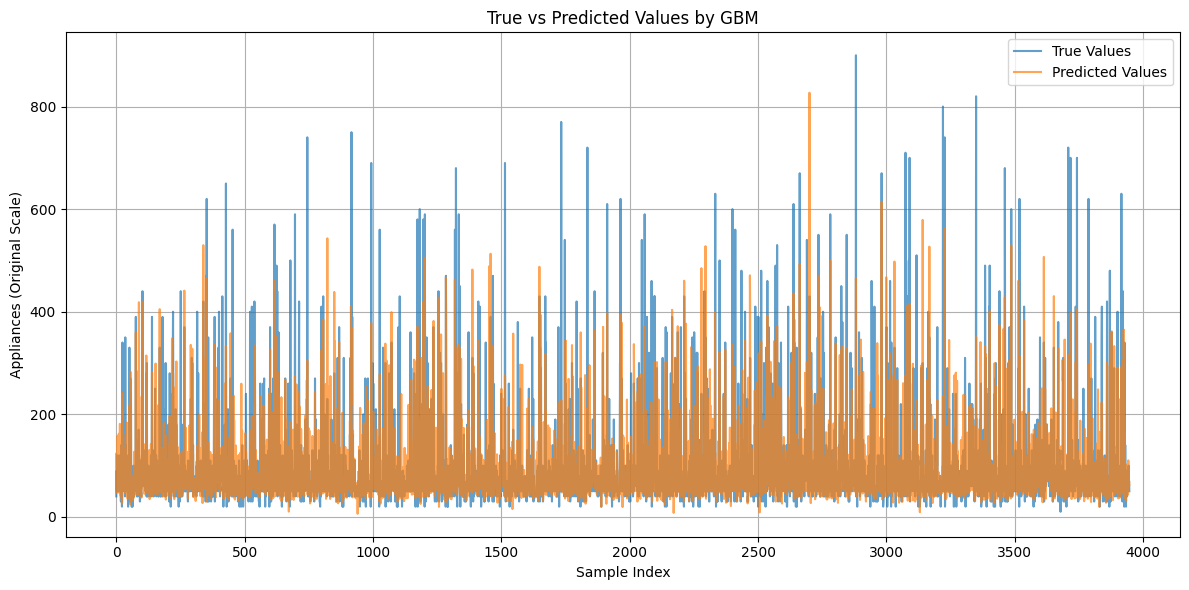

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='True Values', linestyle='-', alpha=0.7)
plt.plot(y_pred_original, label='Predicted Values', linestyle='-', alpha=0.7)
plt.title('True vs Predicted Values by GBM')
plt.xlabel('Sample Index')
plt.ylabel('Appliances (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

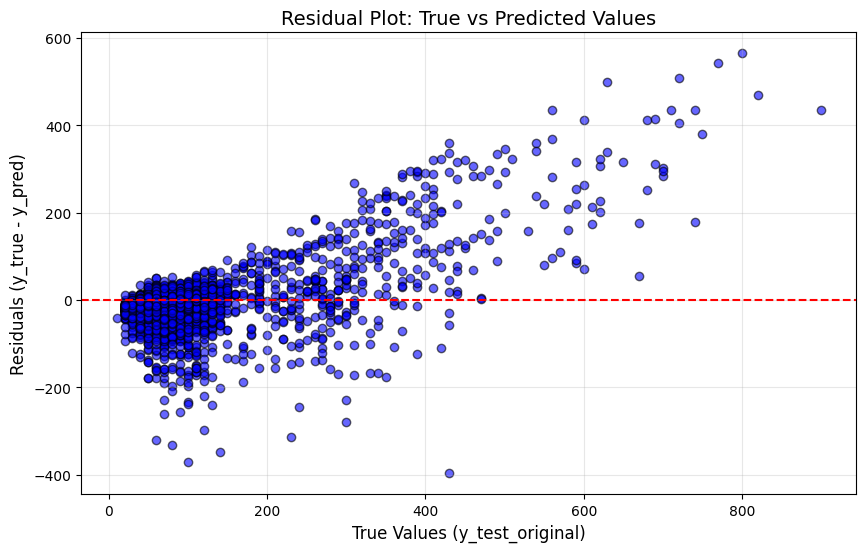

In [ ]:
residuals = y_test_original - y_pred_original

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, residuals, alpha=0.6, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Residual Plot: True vs Predicted Values', fontsize=14)
plt.xlabel('True Values (y_test_original)', fontsize=12)
plt.ylabel('Residuals (y_true - y_pred)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


### Save model

In [ ]:
sklearn_model_save('/content/drive/My Drive/Machine Learning/Final Project/Models/gbm', model, {})